# ChromaDB

## ChromaDB 概要

このチュートリアルでは、ChromaDBの基本的な使い方から中級の利用方法までを紹介します。ChromaDBの構築方法、ベクトルの生成、検索、更新、削除などのトピックを探求します。さらに、データの保存と読み込みの技術についても取り上げます。また、実際のプロジェクト内でChromaDBを活用した実践的なアプリケーションにも触れていきます。






### ChromaDBとは

ChromaDBは、ベクトル埋め込みを格納し、大規模な言語モデル（LLM）アプリケーションを開発・構築するために設計されたオープンソースのベクトルデータベースです。ChromaDBは、LLMアプリケーションを構築するための強力なツールです。高速で効率的で使いやすな特徴を持っています。

### ChromaDBの利点

- **高速で効率的**: ChromaDBは、人気のあるインメモリデータストアであるRedisの上に構築されています。これにより、埋め込みの格納とクエリが非常に高速に行えます。
- **使いやすさ**: ChromaDBにはシンプルで直感的なAPIが備わっており、初めてでも簡単に始めることができます。
- **複数の埋め込みフォーマットのサポート**: ChromaDBは、Word2VecやGloVe、FastTextなど、さまざまな埋め込みフォーマットをサポートしています。
- **最近傍探索のサポート**: ChromaDBは、指定された埋め込みの最近傍を見つけるために使用できます。これは、セマンティック検索や質問応答などのアプリケーションに役立ちます。
- **増分更新のサポート**: ChromaDBは増分で更新することが可能です。これにより、頻繁に更新が必要なアプリケーションに適しています。
- **レプリケーションのサポート**: ChromaDBは複数のサーバーにレプリケーションでき、高い可用性と耐障害性を提供します。
- **ハイブリッドクラウドのサポート**: ChromaDBはローカルおよびクラウドの両方で使用することができます。

### 言語のサポート

| Language     | In-Memory | Client & Server |
|--------------|:---------:|:---------------:|
| Python       | ✔       | ✔             |
| Javascript   | -        | ✔              |
| Ruby         | -        | from @mariochavez |
| C#           | -        | from Microsoft (coming soon) |
| Other?       | ?        | ?              |


## 環境構築

In [2]:
%%capture
%pip install chromadb
%pip install datasets
%pip install sentence-transformers
%pip install openai
%pip install tiktoken

In [3]:
import chromadb
import datasets
import transformers
import openai

print("chromadb version: ", chromadb.__version__)
print("datasets version: ", datasets.__version__)
print("transformers version: ", transformers.__version__)
print("openai version: ", openai.__version__)

chromadb version:  0.4.6
datasets version:  2.14.4
transformers version:  4.31.0
openai version:  0.27.8


In [52]:
import json
import numpy as np
import pandas as pd
import pprint

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

- 多言語のレビュー、画像、感情データの**「unstructured-data-multilingual」**のデータセットを使用します。

- language: ['en', 'ja', 'th']

- https://huggingface.co/datasets/jingwora/unstructured-data-multilingual

In [6]:
from datasets import load_dataset

# データセットの読み込み
dataset = load_dataset("jingwora/unstructured-data-multilingual")

# スプリットの選択
dataset = dataset["ja"]

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating en split:   0%|          | 0/24 [00:00<?, ? examples/s]

Generating ja split:   0%|          | 0/24 [00:00<?, ? examples/s]

Generating th split:   0%|          | 0/24 [00:00<?, ? examples/s]

Dataset({
    features: ['language', 'id', 'product_id', 'category', 'sub_category', 'product_name', 'product_detail', 'image_files', 'review', 'star', 'sentiment'],
    num_rows: 24
})

In [7]:
# データセットをPandasのDataFrameに変換する

df = pd.DataFrame(dataset)

In [8]:
# category_labelとsentiment_labelの列を追加する

df['category_label'] = df['category'].map({'Electronics': 0, 'Health and Beauty': 1})
df['sentiment_label'] = df['sentiment'].map({'positive': 0, 'neutral': 1, 'negative': 2})
df['product_name_label'] = df['product_name'].map({'Smart watch': 0, 'Wall Lamps': 1, 'Supplements': 2, 'Sunblock': 3})

In [9]:
# 埋め込みのためのすべてのテキスト列

df['text'] = df['category'] + ", " + df['sub_category'] + ", " + df['product_detail'] + ", " + df['review'] + ", " + df['sentiment']+ ", " + df['star']


In [10]:
df.head(2)

,language,id,product_id,category,sub_category,product_name,product_detail,image_files,review,star,sentiment,category_label,sentiment_label,product_name_label,text
0,ja,ja-001,ja-001,Electronics,Wearable devices,Smart watch,[ja-001] スマートウォッチ 体表面温度検知 1.9インチ超大画面 腕時計 レディース...,"ja-002-01.jpg, ja-002-02.jpg",軽くてストレス無し！！\n薄型でとても軽い。\nカッコイイと思います。\nすぐにスマホとペア...,4-5,positive,0,0,0,"Electronics, Wearable devices, [ja-001] スマートウォ..."
1,ja,ja-002,ja-001,Electronics,Wearable devices,Smart watch,[ja-001] スマートウォッチ 体表面温度検知 1.9インチ超大画面 腕時計 レディース...,"ja-002-01.jpg, ja-002-02.jpg",大変使いやすく、お手頃な価格で変えたので、とてもよかったです！機会があればまた、購入したいです！,4-5,positive,0,0,0,"Electronics, Wearable devices, [ja-001] スマートウォ..."


In [11]:
# ラベル確認

display(df.groupby(['sentiment_label']).size())

sentiment_label
0    8
1    8
2    8
dtype: int64

## 埋め込み（エンベディング）

Chromaはデフォルトで文のトランスフォーマーを使用します。

https://huggingface.co/intfloat/multilingual-e5-large

https://huggingface.co/spaces/mteb/leaderboard

In [12]:
from sentence_transformers import SentenceTransformer

# キャッシュディレクトリのパスを指定
cache_dir = "/content/drive/MyDrive/models/intfloat_multilingual-e5-large/"

# SentenceTransformerモデルを読み込む
model = SentenceTransformer("intfloat/multilingual-e5-large", cache_folder=cache_dir)

In [13]:
# 埋め込み（エンベディング）

# 埋め込みを生成するための関数
def generate_embeddings(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

df['embeddings'] = df['text'].apply(generate_embeddings)

# 埋め込みの確認
sample_embeddings = df["embeddings"][0]
print(type(sample_embeddings))
embeddings_array = np.array(df['embeddings'].tolist())

print("embeddings length: ", len(sample_embeddings))
print("embeddings max:", embeddings_array.max())
print("embeddings min:", embeddings_array.min())

<class 'list'>
embeddings length:  1024
embeddings max: 0.19916462898254395
embeddings min: -0.13209502398967743


In [14]:
# 散布図を作成する

import numpy as np
from ast import literal_eval
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

def get_scatter_plot(input_df, method="TSNE", label_col="label"):

    df = input_df.copy()

    # numpy array作成
    matrix = np.array(df["embeddings"].apply(lambda x: x).tolist())

    # TSNE modelの計算
    if method == "TSNE":

        tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
        vis_dims = tsne.fit_transform(matrix)

    # PCA modelの計算
    elif method == "PCA":
        pca = PCA(n_components=2)
        pca.fit(matrix)
        vis_dims = pca.transform(matrix)
    else:
        print("please specify method as 'TSNE' or 'PCA'")

    # 散布図の作成
    x = [x for x, y in vis_dims]
    y = [y for x, y in vis_dims]
    color_indices = df[label_col].values

    unique_labels = np.unique(color_indices)
    num_labels = len(unique_labels)

    colormap = matplotlib.colormaps['tab10']

    plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.5)
    for idx, label in enumerate(unique_labels):
        avg_x = np.mean(np.array(x)[df[label_col] == label])
        avg_y = np.mean(np.array(y)[df[label_col] == label])
        color = colormap(idx % num_labels)
        plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

    plt.title(f"Scatter Plot: {method} | {label_col}")

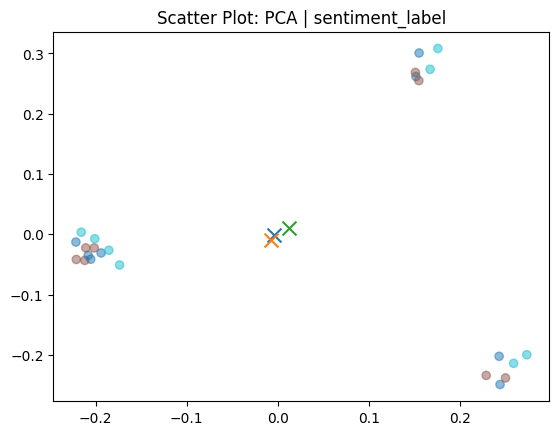

In [15]:
# 散布図

get_scatter_plot(df, method="PCA", label_col="sentiment_label")

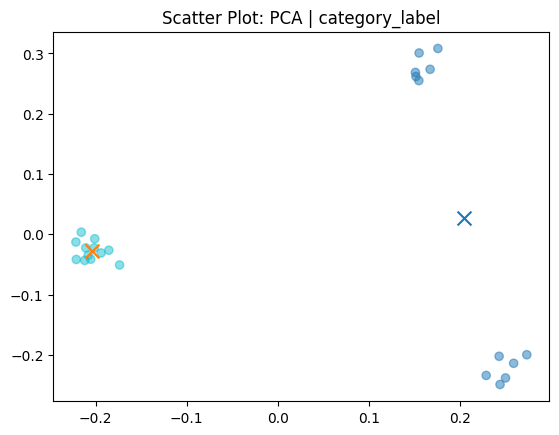

In [16]:
# 散布図

get_scatter_plot(df, method="PCA", label_col="category_label")

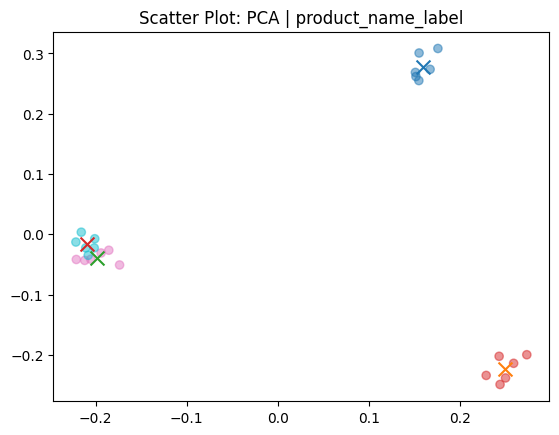

In [17]:
# 散布図

get_scatter_plot(df, method="PCA", label_col="product_name_label")

# ChromaDBの関数

## Clientのメソッド

### EphemeralClient
- Chromaをローカルマシンに保存およびロードするように設定できます。データは自動的に永続化され、存在する場合には起動時にロードされます。

- Create chroma.sqlite3

In [18]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.EphemeralClient()
chroma_client = chromadb.PersistentClient(path="/content/drive/MyDrive/share_KM/VectorDB/chromadb")

### create_collection

- コレクションは、埋め込み、ドキュメント、および追加のメタデータを格納する場所です。

In [33]:
review_cl = chroma_client.create_collection(name="review")

In [34]:
test_cl = chroma_client.create_collection(name="test")

In [35]:
type(review_cl)

chromadb.api.models.Collection.Collection

### heartbeat
- ナノ秒単位のハートビートを返します。クライアントが接続されたままであることを確認するのに役立ちます。

In [36]:
chroma_client.heartbeat()

1692371466218689789

 ### reset

- データベースを空にして完全にリセットします。
- ⚠️ 元に戻すことはできません。

In [37]:
# chroma_client.reset()

### get_collection
- 既存のコレクションからコレクションオブジェクトを取得します
- ```name```: コレクション名

In [38]:
review_cl = chroma_client.get_collection(name="review")

print(type(review_cl))

<class 'chromadb.api.models.Collection.Collection'>


### get_or_create_collection

- 既存のコレクションからコレクションオブジェクトを名前で取得し、存在しない場合は作成します。

In [39]:
review_cl = chroma_client.get_or_create_collection(name="review")

print(type(review_cl))

<class 'chromadb.api.models.Collection.Collection'>


### list_collections
- すべてのコレクションをリストするために使います。

In [40]:
collections = chroma_client.list_collections()

for collection in collections:
  print(collection.name)

test
review


### delete_collection
- コレクションと関連するすべての埋め込み、ドキュメント、およびメタデータを削除します。⚠️元に戻せません。

In [41]:
chroma_client.delete_collection(name="test")

## Methods on Collection

### add

- コレクションにテキストドキュメントを追加します。

- パラメータ:
  - ```documents```: ドキュメントのリスト。
  - ```embedding```: ドキュメントの埋め込みのオプションのリスト。
  - ```ids```: ドキュメントのオプションのIDのリスト。
  - ```collection_name```: 作成するコレクションの名前。
  - ```persist_directory```: コレクションデータを保存するディレクトリ。
  - ```client```: オプションのClientオブジェクト。

In [42]:
# ドキュメント、埋め込み、およびメタデータを追加します。

review_cl.add(
    documents=df["review"].tolist(),
    embeddings=df["embeddings"].tolist(),
    metadatas=[
        {
            "language": language,
            "product_id": product_id,
            "category": category,
            "sub_category": sub_category,
            "product_name": product_name,
            "image_files": image_files,
            "sentiment": sentiment
        }
        for language, product_id, category, sub_category, product_name, image_files, sentiment
        in zip(
            df["language"].tolist(),
            df["product_id"].tolist(),
            df["category"].tolist(),
            df["sub_category"].tolist(),
            df["product_name"].tolist(),
            df["image_files"].tolist(),
            df["sentiment"].tolist()
        )
    ],
    ids=df["id"].tolist()
)

### peek

- 指定しない限り、コレクション内の最初の5つのアイテムのリストを返します。

In [54]:
print(review_cl.peek(1))

{'ids': ['ja-001'], 'embeddings': [[-0.0033082470763474703, -0.021322360262274742, -0.045499153435230255, -0.04512368515133858, 0.037261173129081726, -0.0547495074570179, -0.02079579420387745, 0.04622034355998039, 0.06176404654979706, -0.02581595629453659, 0.04663693159818649, 0.038380734622478485, -0.016167711466550827, -0.024133270606398582, -0.04513375833630562, 0.0036329992581158876, -0.02700548619031906, 0.021578505635261536, 0.009692693129181862, -0.016088120639324188, 0.04648549109697342, -0.01261052954941988, -0.04678773134946823, -0.01849237270653248, -0.02850755862891674, -0.0028610199224203825, -0.03667747974395752, -0.041717130690813065, -0.002259322674944997, -0.006174473557621241, 0.0038197070825845003, -0.0033528911881148815, -0.0511566586792469, -0.059295427054166794, -0.016534365713596344, 0.03345080092549324, 0.013875028118491173, 0.052122604101896286, -0.029218364506959915, 0.02115067094564438, -0.015810366719961166, 0.02527354471385479, 0.022213159129023552, -0.0257

### count
- コレクション内のアイテムの数を返します。

In [44]:
review_cl.count()

24

### modify
- コレクションの名前を変更します。

In [45]:
review_cl.modify(name="review")

### get
- パラメータ:
  - ```ids```: IDによってアイテムを取得します
  - ```where```: メタデータの条件

In [51]:
# get ids

results = review_cl.get(
    ids=["ja-001"],
)

print(type(results))
pprint.pprint(results)

<class 'dict'>
{'documents': ['軽くてストレス無し！！\n'
               '薄型でとても軽い。\n'
               'カッコイイと思います。\n'
               'すぐにスマホとペアリング出来ました。\n'
               '商品が来るのも早かったので助かりました。\n'
               '軽くて良い&#11093;&#65039;\n'
               '写真追加しました。'],
 'embeddings': None,
 'ids': ['ja-001'],
 'metadatas': [{'category': 'Electronics',
                'image_files': 'ja-002-01.jpg, ja-002-02.jpg',
                'language': 'ja',
                'product_id': 'ja-001',
                'product_name': 'Smart watch',
                'sentiment': 'positive',
                'sub_category': 'Wearable devices'}]}


In [55]:
# get ids + where

results = review_cl.get(
    ids=["ja-001", "ja-002", "ja-003"],
    where={"sentiment": "positive"}
)

pprint.pprint(results)

{'documents': ['軽くてストレス無し！！\n'
               '薄型でとても軽い。\n'
               'カッコイイと思います。\n'
               'すぐにスマホとペアリング出来ました。\n'
               '商品が来るのも早かったので助かりました。\n'
               '軽くて良い&#11093;&#65039;\n'
               '写真追加しました。',
               '大変使いやすく、お手頃な価格で変えたので、とてもよかったです！機会があればまた、購入したいです！'],
 'embeddings': None,
 'ids': ['ja-001', 'ja-002'],
 'metadatas': [{'category': 'Electronics',
                'image_files': 'ja-002-01.jpg, ja-002-02.jpg',
                'language': 'ja',
                'product_id': 'ja-001',
                'product_name': 'Smart watch',
                'sentiment': 'positive',
                'sub_category': 'Wearable devices'},
               {'category': 'Electronics',
                'image_files': 'ja-002-01.jpg, ja-002-02.jpg',
                'language': 'ja',
                'product_id': 'ja-001',
                'product_name': 'Smart watch',
                'sentiment': 'positive',
                'sub_category': 'Wearable devices'}]}


### query

- Query the collection
- Parameters:
  - ```query_texts```: input text (defualt embeddings)
  - ```generate_embeddings```: input embedding
  - ```n_results```: number of returned ids

In [56]:
# query

query_embeddings = generate_embeddings("Smart watch")
results = review_cl.query(query_embeddings=query_embeddings,
                          n_results=2,
                          )

pprint.pprint(results)

{'distances': [[0.36229462681363606, 0.36564063800894087]],
 'documents': [['大変使いやすく、お手頃な価格で変えたので、とてもよかったです！機会があればまた、購入したいです！',
                'LINEや電話の通知設定がなかなかうまく行きません。ここ2週間くらい使用してますが、通知がうまくいかないのが不満なくらいで、他の機能は満足してます。']],
 'embeddings': None,
 'ids': [['ja-002', 'ja-004']],
 'metadatas': [[{'category': 'Electronics',
                 'image_files': 'ja-002-01.jpg, ja-002-02.jpg',
                 'language': 'ja',
                 'product_id': 'ja-001',
                 'product_name': 'Smart watch',
                 'sentiment': 'positive',
                 'sub_category': 'Wearable devices'},
                {'category': 'Electronics',
                 'image_files': 'ja-002-01.jpg, ja-002-02.jpg',
                 'language': 'ja',
                 'product_id': 'ja-001',
                 'product_name': 'Smart watch',
                 'sentiment': 'neutral',
                 'sub_category': 'Wearable devices'}]]}


In [57]:
# query + where

query_embeddings = generate_embeddings("The worst and terrify review")
results = review_cl.query(query_embeddings=query_embeddings,
                          where={"sentiment": "negative"},
                          n_results=1,
                          )
pprint.pprint(results)

{'distances': [[0.4398985927543045]],
 'documents': [['不良品\n到着後段ボールを開封すると角が潰れて漏れていたようです。']],
 'embeddings': None,
 'ids': [['ja-018']],
 'metadatas': [[{'category': 'Health and Beauty',
                 'image_files': 'ja-003-01.jpg, ja-003-02.jpg',
                 'language': 'ja',
                 'product_id': 'ja-003',
                 'product_name': 'Supplements',
                 'sentiment': 'negative',
                 'sub_category': 'Health'}]]}


In [61]:
# query + where + where_document

results = review_cl.query(query_embeddings=query_embeddings,
                          where={"sentiment": "negative"},
                          where_document={"$contains":"不良品"},
                          n_results=1,
                          )
pprint.pprint(results)

{'distances': [[0.4398985927543045]],
 'documents': [['不良品\n到着後段ボールを開封すると角が潰れて漏れていたようです。']],
 'embeddings': None,
 'ids': [['ja-018']],
 'metadatas': [[{'category': 'Health and Beauty',
                 'image_files': 'ja-003-01.jpg, ja-003-02.jpg',
                 'language': 'ja',
                 'product_id': 'ja-003',
                 'product_name': 'Supplements',
                 'sentiment': 'negative',
                 'sub_category': 'Health'}]]}


### delete

- ドキュメントを削除します。

In [62]:
review_cl.delete(ids=["ja-020"])

In [63]:
review_cl.get(
    ids=["ja-020"],
)

{'ids': [], 'embeddings': None, 'metadatas': [], 'documents': []}

### update

- ドキュメントを更新します。

In [64]:
review_cl.get(
    ids=["ja-021"],
)

{'ids': ['ja-021'],
 'embeddings': None,
 'metadatas': [{'category': 'Health and Beauty',
   'image_files': 'ja-004-01.jpg, ja-004-02.jpg',
   'language': 'ja',
   'product_id': 'ja-004',
   'product_name': 'Sunblock',
   'sentiment': 'neutral',
   'sub_category': 'Beauty'}],
 'documents': ['ローズを買いました。\nトーンアップはしますが、脂性肌なのでヨレてしまうのが残念です。']}

In [65]:
review_cl.update(
    ids=["ja-021"],
    metadatas=[{"product_name": "Sunblock_new"}],
)

In [67]:
review_cl.get(
    ids=["ja-021"],
)

{'ids': ['ja-021'],
 'embeddings': None,
 'metadatas': [{'category': 'Health and Beauty',
   'image_files': 'ja-004-01.jpg, ja-004-02.jpg',
   'language': 'ja',
   'product_id': 'ja-004',
   'product_name': 'Sunblock_new',
   'sentiment': 'neutral',
   'sub_category': 'Beauty'}],
 'documents': ['ローズを買いました。\nトーンアップはしますが、脂性肌なのでヨレてしまうのが残念です。']}

### upsert

- 新しいアイテムは追加され、既存のアイテムは更新されます。

In [68]:
# upsert items

review_cl.upsert(
    documents=df["review"].tolist(),
    embeddings=df["embeddings"].tolist(),
    metadatas=[
        {
            "language": language,
            "product_id": product_id,
            "category": category,
            "sub_category": sub_category,
            "product_name": product_name,
            "image_files": image_files,
            "sentiment": sentiment
        }
        for language, product_id, category, sub_category, product_name, image_files, sentiment
        in zip(
            df["language"].tolist(),
            df["product_id"].tolist(),
            df["category"].tolist(),
            df["sub_category"].tolist(),
            df["product_name"].tolist(),
            df["image_files"].tolist(),
            df["sentiment"].tolist()
        )
    ],
    ids=df["id"].tolist()
)

## embedding
- デフォルトでは、Chromaは埋め込みを作成するためにSentence Transformersの```all-MiniLM-L6-v2```モデルを使用します。
- https://www.sbert.net/docs/pretrained_models.html

### DefaultEmbeddingFunction

In [ ]:
from chromadb.utils import embedding_functions

default_ef = embedding_functions.DefaultEmbeddingFunction()

default_ef

### SentenceTransformerEmbeddingFunction

In [ ]:
# SentenceTransformerを読み込みます。
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="intfloat/multilingual-e5-large")

sentence_transformer_ef

### OpenAI

In [ ]:
import os
import getpass
import openai

APIKEY = getpass.getpass("APIKEY: ")
os.environ["OPENAI_API_KEY"] = APIKEY
openai.api_key = os.environ["OPENAI_API_KEY"]

APIKEY: ··········


In [ ]:
from chromadb.utils import embedding_functions

def text_embedding(text):
    response = openai.Embedding.create(model="text-embedding-ada-002", input=text)
    return response["data"][0]["embedding"]

openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.environ["OPENAI_API_KEY"],
                model_name="text-embedding-ada-002"
            )

In [ ]:
embeddings = text_embedding("test")
print(embeddings)

[-0.0017262666951864958, -0.013922297395765781, 0.0016728137852624059, -0.018408838659524918, -0.0071258884854614735, 0.018563061952590942, -0.00954090990126133, -0.029190557077527046, -0.006235590670257807, -0.01467940118163824, 0.011791190132498741, 0.007153929676860571, 0.0013932812726125121, -0.01178418006747961, -0.007090837694704533, 0.01302498858422041, 0.046940434724092484, 0.0009928224608302116, 0.0170208141207695, -0.02868582122027874, 0.010585431940853596, 0.007311659399420023, -0.003193155163899064, 0.0016386389033868909, -0.03011590614914894, -0.014791564084589481, 0.0017744619399309158, -0.03701396286487579, -0.003161609172821045, 0.0028969733975827694, 0.018885532394051552, -0.028882106766104698, -0.0267089381814003, -0.029807455837726593, -0.023315992206335068, -0.008412264287471771, -0.00388366193510592, -0.013943327590823174, 0.017918122932314873, -7.968648424139246e-05, 0.01041017659008503, 0.01330539770424366, 0.005548588931560516, -0.014623318798840046, -0.00316686

In [ ]:
# embedding_functionを設定します。
review_cl = chroma_client.get_collection(name="review", embedding_function=openai_ef)

review_cl

Collection(name=review)

References:

- Chroma docs: https://docs.trychroma.com/
- api-reference: https://docs.trychroma.com/api-reference
- datasets: https://huggingface.co/datasets/jingwora/unstructured-data-multilingual
